# Extended Example With Covariance Matrices. 

In [1]:
import autograd
from autograd import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import paragami

# Use the original scipy ("osp") for functions we don't need to differentiate.
# When using scipy functions in functions that are passed to autograd,
# use autograd.scipy instead.
import scipy as osp

In this example, we will consider flattening and folding a simple symmetric positive semi-definite matrix:

$$
A = \left[
\begin{matrix}
a_{11} & a_{12} & a_{13}  \\
a_{21} & a_{22} & a_{23}  \\
a_{31} & a_{32} & a_{33}  \\
\end{matrix}
\right].
$$

Of course, symmetry and positive semi-definiteness impose constraints on the entries $a_{ij}$ of $A$.

## Flattening and Folding.

### In the Original Space.

Let us first consider how to represent $A$ as a vector, which we call simply *flattening*, and then as an unconstrained vector, which we call *free flattening*.

When a parameter is flattened, it is simply re-shaped as a vector.  Every number that was in the original parameter will occur exactly once in the flattened shape.  (In the present case of a matrix, this is exactly the same as ``np.flatten``.)

$$
A = \left[
\begin{matrix}
a_{11} & a_{12} & a_{13}  \\
a_{21} & a_{22} & a_{23}  \\
a_{31} & a_{32} & a_{33}  \\
\end{matrix}
\right]
\xrightarrow{flatten}
A_{flat} = 
\left[
\begin{matrix}
a_{flat,1} \\
a_{flat,2} \\
a_{flat,3} \\
a_{flat,4} \\
a_{flat,5} \\
a_{flat,6} \\
a_{flat,7} \\
a_{flat,8} \\
a_{flat,9} \\
\end{matrix}\right]
=
\left[
\begin{matrix}
a_{11} \\
a_{12} \\
a_{13} \\
a_{21} \\
a_{22} \\
a_{23} \\
a_{31} \\
a_{32} \\
a_{33} \\
\end{matrix}
\right]
$$

Converting to and from $A$ and $A_{flat}$ can be done with the `flatten` method of a `paragami.PSDSymmetricMatrixPattern` pattern.  

For the moment, because we are flattening, not free flattening, we use the option `free=False`.  We will discuss the `free=True` option shortly.

In [2]:
# A sample positive semi-definite matrix.
a = np.eye(3) + np.random.random((3, 3))
a = 0.5 * (a + a.T)

# Define a pattern and fold.
a_pattern = paragami.PSDSymmetricMatrixPattern(size=3)
a_flat = a_pattern.flatten(a, free=False)

print('Now, a_flat contains the elements of a exactly as shown in the formula above.\n')
print('a:\n{}\n'.format(a))
print('a_flat:\n{}\n'.format(a_flat))

Now, a_flat contains the elements of a exactly as shown in the formula above.

a:
[[1.86520859 0.78134038 0.72375918]
 [0.78134038 1.08398334 0.457461  ]
 [0.72375918 0.457461   1.04752021]]

a_flat:
[1.86520859 0.78134038 0.72375918 0.78134038 1.08398334 0.457461
 0.72375918 0.457461   1.04752021]



We can also convert from $A_{flat}$ back to $A$ by 'folding'.

In [3]:
print('Folding the flattened value recovers the original matrix.\n')
a_fold = a_pattern.fold(a_flat, free=False)
print('a:\n{}\n'.format(a))
print('a_fold:\n{}\n'.format(a_fold))

Folding the flattened value recovers the original matrix.

a:
[[1.86520859 0.78134038 0.72375918]
 [0.78134038 1.08398334 0.457461  ]
 [0.72375918 0.457461   1.04752021]]

a_fold:
[[1.86520859 0.78134038 0.72375918]
 [0.78134038 1.08398334 0.457461  ]
 [0.72375918 0.457461   1.04752021]]



By default, flattening and folding perform checks to make sure the result is a valid instance of the parameter type -- in this case, a symmetric positive definite matrix. 

In [4]:
print('The diagonal of a positive semi-definite matrix must not be less',
      'than 0, and folding checks this when validate=True, which it is by default:\n')
a_flat_bad = np.array([-1, 0, 0,  0, 0, 0,  0, 0, 0])
print('A bad folded value: {}'.format(a_flat_bad))
try:
    a_fold_bad = a_pattern.fold(a_flat_bad, free=False)
except ValueError as err:
    print('Folding with a_pattern raised the following ValueError:\n{}'.format(err))

print('\nIf validate is false, folding will produce an invalid matrix without an error:\n')
a_fold_bad = a_pattern.fold(a_flat_bad, free=False, validate=False)
print('Folding a non-pd matrix with validate=False:\n{}'.format(a_fold_bad))

print('\nHowever, it will not produce a matrix of the wrong shape even when validate is False:\n')
a_flat_very_bad = np.array([1, 0, 0])
print('A very bad folded value: {}.'.format(a_flat_very_bad))
try:
    a_fold_very_bad = a_pattern.fold(a_flat_very_bad, free=False, validate=False)
except ValueError as err:
    print('Folding with a_pattern raised the following ValueError:\n{}'.format(err))

The diagonal of a positive semi-definite matrix must not be less than 0, and folding checks this when validate=True, which it is by default:

A bad folded value: [-1  0  0  0  0  0  0  0  0]
Folding with a_pattern raised the following ValueError:
Diagonal is less than the lower bound 0.0.

If validate is false, folding will produce an invalid matrix without an error:

Folding a non-pd matrix with validate=False:
[[-1  0  0]
 [ 0  0  0]
 [ 0  0  0]]

However, it will not produce a matrix of the wrong shape even when validate is False:

A very bad folded value: [1 0 0].
Folding with a_pattern raised the following ValueError:
Wrong length for PSDSymmetricMatrix flat value.


### In an Unconstrained Space: "Free" Flattening and Folding.

Ordinary flattening converts a 3x3 symmetric PSD matrix into a 9-d vector.  However, as seen above, not every 9-d vector is a valid 3x3 symmetric positive definite matrix.  It is useful to have an "free" flattened representation of a parameter, where every finite value of the free flattened vector corresponds is guaranteed valid.

To accomplish this for a symmetric positive definite matrix, we consider the Cholesky decomposition $A_{chol}$. This is an lower-triangular matrix with positive diagonal entries such that $A = A_{chol} A_{chol}^T$.  By taking the log of the diagonal of $A_{chol}$ and stacking the non-zero entries, we can construct a 6-d vector, every value of which corresponds to a symmetric PSD matrix.

$$
% A \xrightarrow{\textrm{free flatten}} A_{freeflat} \quad\quad \textrm{where} \\
A \xrightarrow{}
A_{chol} = 
\left[
\begin{matrix}
\alpha_{11} & 0 & 0  \\
\alpha_{21} & \alpha_{22} & 0  \\
\alpha_{31} & \alpha_{32} & \alpha_{33}  \\
\end{matrix}
\right] \xrightarrow{}
A_{freeflat} =
\left[
\begin{matrix}
\log(\alpha_{11}) \\
\alpha_{21} \\
\alpha_{31} \\
\log(\alpha_{22})\\
\alpha_{32} \\
\log(\alpha_{33})
\end{matrix}
\right].
$$

The details of the freeing transform aren't important to the end user, as `paragami` takes care of the transformation behind the scenes with the option `free=True`.  We denote the flattened $A$ in the free parameterization as $A_{freeflat}$.

In [5]:
print('The free flat value a_freeflat is not immediately recognizable as a.\n')
a_freeflat = a_pattern.flatten(a, free=True)
print('a:\n{}\n'.format(a))
print('a_freeflat:\n{}\n'.format(a_freeflat))

print('However, it transforms correctly back to a when folded.\n')
a_freefold = a_pattern.fold(a_freeflat, free=True)
print('a_fold:\n{}\n'.format(a_freefold))

The free flat value a_freeflat is not immediately recognizable as a.

a:
[[1.86520859 0.78134038 0.72375918]
 [0.78134038 1.08398334 0.457461  ]
 [0.72375918 0.457461   1.04752021]]

a_freeflat:
[ 0.31168645  0.57210609 -0.13940876  0.52994449  0.17735537 -0.15378995]

However, it transforms correctly back to a when folded.

a_fold:
[[1.86520859 0.78134038 0.72375918]
 [0.78134038 1.08398334 0.457461  ]
 [0.72375918 0.457461   1.04752021]]



Any length-six vector will free fold back to a valid PSD matrix up to floating point error.  Let's draw 100 random vectors, fold them, and check that this is true.


In [6]:
# Draw random free vectors and confirm that they are positive semi definite.
def assert_is_pd(mat):
    eigvals = np.linalg.eigvals(mat)
    assert np.min(eigvals) >= -1e-8
for draw in range(100):
    a_rand_freeflat = np.random.normal(scale=2, size=(6, ))
    a_rand_fold = a_pattern.fold(a_rand_freeflat, free=True)
    assert_is_pd(a_rand_fold)

## Using Flattening and Folding for Optimization.

### An Example Model.

Suppose we are interested in optimizing some function of $A$, say, a normal model in which the data $x_n \sim \mathcal{N}(0, A)$.  Specifically, Let the data be $X = \left(x_1, ..., x_N\right)$, where $x_n \in \mathbb{R}^3$, and write a loss function as

$$
\ell\left(X, A\right) =
    -\sum_{n=1}^N \log P(x_n | A) =
    \frac{1}{2}\sum_{n=1}^N \left(x_n^T A^{-1} x_n - \log|A|\right) 
$$

Let's simulate some data under this model.

In [7]:
np.random.seed(42)

num_obs = 100

# True value of A
true_a = np.eye(3) * np.diag(np.array([1, 2, 3])) + np.random.random((3, 3)) * 0.1
true_a = 0.5 * (true_a + true_a.T)

# Data
def draw_data(num_obs, true_a):
    return np.random.multivariate_normal(
        mean=np.zeros(3), cov=true_a, size=(num_obs, ))

x = draw_data(num_obs, true_a)
print('X shape: {}'.format(x.shape))

def get_loss(x, a):
    num_obs = x.shape[0]
    a_inv = np.linalg.inv(a)
    a_det_sign, a_log_det = np.linalg.slogdet(a)
    assert a_det_sign > 0
    return 0.5 * (np.einsum('ni,ij,nj', x, a_inv, x) + num_obs * a_log_det)

print('Loss at true parameter: {}'.format(get_loss(x, true_a)))

X shape: (100, 3)
Loss at true parameter: 242.28536625488033


### Using ``autograd`` and ``scipy.optimize`` with ``paragami``.

We would like to minimize the function `loss` using tools like `scipy.optimize.minimize`.  Standard optimization functions take vectors, not matrices, as input, and often require the vector to take valid values in the entire domain.

As-written, our loss function takes a positive definite matrix as an input.  We can wrap the loss as a funciton of the free flattened value using the `paragami.FlattenedFunction` class.  That is, we want to define a function $\ell_{freeflat}$ so that

$$
\ell_{freeflat}(X, A_{freeflat}) = \ell(X, A).
$$


The resulting function can be passed directly to `autograd` and `scipy.optimize`, and we can estimate

$$
\hat{A}_{freeflat} := \mathrm{argmin}_{A_{freeflat}} \ell_{freeflat}(X, A_{freeflat})
$$

In [8]:
# The arguments mean we're flatting the function get_loss, using
# the pattern a_pattern, with free parameterization, and the paramater
# is the second one (argnums uses 0-indexing like autograd).
get_freeflat_loss = paragami.FlattenedFunction(
    original_fun=get_loss, patterns=a_pattern, free=True, argnums=1)

print('The two losses are the same when evalated on the folded and flat values:\n')
print('Original loss:\t\t{}'.format(get_loss(x, true_a)))
true_a_freeflat = a_pattern.flatten(true_a, free=True)
print('Free-flattened loss: \t{}'.format(
    get_freeflat_loss(x, true_a_freeflat)))

print('\nNow, use the flattened function to optimize with autograd.\n')

get_freeflat_loss_grad = autograd.grad(get_freeflat_loss, argnum=1)
get_freeflat_loss_hessian = autograd.hessian(get_freeflat_loss, argnum=1)

def get_optimum(x):
    loss_opt = osp.optimize.minimize(
        method='trust-ncg',
        x0=np.zeros(a_pattern.flat_length(free=True)),
        fun=lambda par: get_freeflat_loss(x, par),
        jac=lambda par: get_freeflat_loss_grad(x, par),
        hess=lambda par: get_freeflat_loss_hessian(x, par),
        options={'gtol': 1e-8, 'disp': False})
    return loss_opt

loss_opt = get_optimum(x)
print('Optimization successful: {}\nOptimal value: {}'.format(
    loss_opt.success, loss_opt.fun))

The two losses are the same when evalated on the folded and flat values:

Original loss:		242.28536625488033
Free-flattened loss: 	242.28536625488036

Now, use the flattened function to optimize with autograd.

Optimization successful: False
Optimal value: 239.37556057055355


The optimization was in the free flattened space, so to get the optimal value of $A$ we must fold it.   We can see that the optimal value is close to the true value of $A$, though it differs due to randomness in $X$.

In [9]:
optimal_freeflat_a = loss_opt.x
optimal_a = a_pattern.fold(optimal_freeflat_a, free=True)
print('True a:\n{}\n\nOptimal a:\n{}'.format(true_a, optimal_a))

True a:
[[1.03745401 0.07746864 0.03950388]
 [0.07746864 2.01560186 0.05110853]
 [0.03950388 0.05110853 3.0601115 ]]

Optimal a:
[[ 1.13076002 -0.16382566  0.18449819]
 [-0.16382566  1.97854146  0.3020592 ]
 [ 0.18449819  0.3020592   2.78831733]]


## Using Flattening and Folding with the Fisher Information for Frequentist Uncertainty.

### Fisher Information and the Delta Method.

Suppose we wanted to use the Hessian of the objective (the observed Fisher information) to estimate a frequentist confidence region for $A$.  In standard notation, covariance is of a vector, so we can write what we want in terms of $A_{flat}$ as $\mathrm{Cov}(A_{flat})$.
The covariance between two elements of $A_{flat}$ corresponds to that between two elements of $A$.  For example, using the notation given above,

$$
\mathrm{Cov}(a_{flat,1}, a_{flat,2}) = \mathrm{Cov}(a_{11}, a_{12}) = \mathrm{Cov}(a_{11}, a_{21})\\
\mathrm{Var}(a_{flat,4}) = \mathrm{Var}(a_{21}) = \mathrm{Var}(a_{12}),
$$
etc.

Here, we will use the observed Fisher information of $\ell_{freeflat}$ and the Delta method to estimate $\mathrm{Cov}(A_{flat})$.

$$
\begin{aligned}
\mathrm{Cov}(A_{freeflat}) &\approx
-\left( \left.
\frac{\partial^2 \ell_{freeflat}}{\partial A_{freeflat} \partial A_{freeflat}^T}
\right|_{\hat{A}_{freeflat}} \right)^{-1}
&\quad\textrm{(Fisher information)}
\\
\mathrm{Cov}(A_{free}) &\approx
\left(\frac{d A_{free}}{dA_{freeflat}^T}\right)
\mathrm{Cov}(A_{freeflat})
\left(\frac{d A_{free}}{dA_{freeflat}^T}\right)^T
&\quad\textrm{(Delta method)}
\end{aligned}
$$

The Hessian required for the covariance can be calculated directly using ``autograd``.  (Note that the loss is the negative of the log likelihood.)  The shape is, of course, the size of $A_{freeflat}$.

In [10]:
fisher_info = -1 * get_freeflat_loss_hessian(x, loss_opt.x)
print("The shape of the Fisher information amtrix is {}.".format(fisher_info.shape))

The shape of the Fisher information amtrix is (6, 6).


The Jacobian matrix $\frac{d A_{free}}{dA_{freeflat}^T}$ of the "unfreeing transform" $A_{free} = A_{free}(A_{freeflat})$ is provided by ``paragami`` as a function of the *folded* parameter.  Following standard notation for Jacobian matrices, the rows correspond to $A_{flat}$, the output of the unfreeing transform, and the columns correspond to $A_{freeflat}$, the input to the unfreeing transform.

By default this Jacobian matrix is sparse (in large problems, most flat parameters are independent of most free flat parameters), but a dense matrix is fine in this small problem, so we use ``sparse=False``.



In [11]:
freeing_jac = a_pattern.unfreeing_jacobian(optimal_a, sparse=False)
print("The shape of the Jacobian matrix is {}.".format(freeing_jac.shape))

The shape of the Jacobian matrix is (9, 6).


We can now plug in to estimate the covariance.

In [12]:
# Estimate the covariance of the flattened value using the Hessian at the optimum.
a_flattened_cov = -1 * freeing_jac @ np.linalg.solve(fisher_info, freeing_jac.T)


### A Cautionary Note on Using the Fisher Information With Constrained Variables.

Note that the estimated covariance is rank-deficient.  This is expected, since, for example, $A_{12}$ and $A_{21}$ cannot vary independently.


In [13]:
print('The shape of the covariance matrix is {}.'.format(a_flattened_cov.shape))
print('The rank of the covariance matrix is {}.'.format(np.linalg.matrix_rank(a_flattened_cov)))

The shape of the covariance matrix is (9, 9).
The rank of the covariance matrix is 6.


Suppose we had erronously defined the function $\ell_{flat}(A_{flat})$ and tried to estimate the covariance of $A$ using the Hessian of $\ell_{flat}$.  Then the resulting Hessian would have been *full rank*, because the loss function ``get_loss`` does not enforce the constraint that $A$ be symmetric.  

In [14]:
print('An example of an erroneous use of Fisher information!')
get_flat_loss = paragami.FlattenedFunction(
    original_fun=get_loss, patterns=a_pattern, free=False, argnums=1)
get_flat_loss_hessian = autograd.hessian(get_flat_loss, argnum=1)
a_flat_opt = a_pattern.flatten(optimal_a, free=False)
bad_fisher_info = get_flat_loss_hessian(x, a_flat_opt)

bad_a_flattened_cov = -1 * np.linalg.inv(bad_fisher_info)

print('The shape of the erroneous covariance matrix is {}.'.format(bad_a_flattened_cov.shape))
print('The rank of the erroneous covariance matrix is {}.'.format(np.linalg.matrix_rank(bad_a_flattened_cov)))

An example of an erroneous use of Fisher information!
The shape of the erroneous covariance matrix is (9, 9).
The rank of the erroneous covariance matrix is 9.


Theoretically, we are not justified using the Hessian of $\ell_{flat}$ to estimate the covariance of its optimizer because the optimum is not "interior" -- that is, the argument $A_{flat}$ cannot take legal values in a neighborhood of the optimum, since such values may not be valid covariance matrices.  Overcoming this difficulty is a key advantage of using unconstrained parameterizations.

### Inspecting and Checking the Result.

This shape of $\mathrm{Cov}(A_{flat})$ is inconvenient because it's not obvious visually which entry of the flattened vector corresponds to which element of $A$.  Again, we can use folding to put the estimated marginal standard deviations in a readable shape.

Because the result is not a valid covariance matrix, and we are just using the pattern for its shape, we set `validate` to `False`.

In [15]:
a_pattern.verify = False
a_sd = a_pattern.fold(np.sqrt(np.diag(a_flattened_cov)), free=False, validate=False)
print('The marginal standard deviations of the elements of A:\n{}'.format(a_sd))

The marginal standard deviations of the elements of A:
[[0.15991362 0.15046908 0.17852051]
 [0.15046908 0.27980802 0.23681303]
 [0.17852051 0.23681303 0.39432762]]


As a sanity check, we can compare this estimated covariance with the variability incurred by drawing new datasets and re-optimizing.

In [20]:
num_sims = 20
optimal_a_draws = np.empty((num_sims, ) + true_a.shape)
for sim in range(num_sims):
    new_x = draw_data(num_obs, true_a)
    new_loss_opt = get_optimum(new_x)
    optimal_a_draws[sim] = a_pattern.fold(new_loss_opt.x, free=True)

Actual standard deviation:
[[0.11447968 0.12298773 0.1601474 ]
 [0.12298773 0.29224341 0.22676115]
 [0.1601474  0.22676115 0.50484798]]
Estimated standard deviation:
[[0.15991362 0.15046908 0.17852051]
 [0.15046908 0.27980802 0.23681303]
 [0.17852051 0.23681303 0.39432762]]


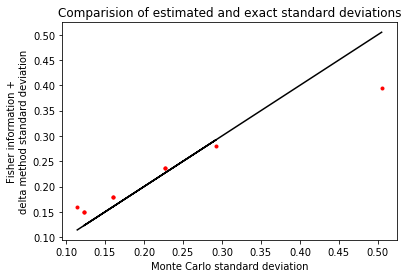

In [21]:
a_sd_monte_carlo = np.std(optimal_a_draws, axis=0)

plt.plot(a_sd_monte_carlo.flatten(), a_sd.flatten(), 'r.')
plt.plot(a_sd_monte_carlo.flatten(), a_sd_monte_carlo.flatten(), 'k')
plt.xlabel('Monte Carlo standard deviation')
plt.ylabel('Fisher information +\ndelta method standard deviation')
plt.title('Comparision of estimated and exact standard deviations')

print('Actual standard deviation:\n{}'.format(a_sd_monte_carlo))
print('Estimated standard deviation:\n{}'.format(a_sd))